## Connect to Local Runtime
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [221]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons import layers as addon_layers
import importlib

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [54]:
print(tf.__version__)
# print(addon_layers.__version__)

2.7.0


In [92]:
def assert_shape(x, exp_shape):
    assert x.shape == exp_shape, f"Expected {exp_shape} got {x.shape}"

In [55]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [135]:
import resnet
import data_utils

In [78]:
## Reload Module
importlib.reload(resnet)

<module 'resnet' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\resnet.py'>

In [80]:
## Test Module Import
# test_res1dblock = resnet.ResnetConv1DBlock(kernel_size=3, filters=32)
test_dilated_res_stack = resnet.DilatedResnet1D(32, 3, dilation_factor=3, reverse_dilation=True)

## DataSet

In [3]:
## Local Data-path
DATA_PATH = "GENERATIVE_DATA/LJSpeech-1.1/wavs/*.wav"

In [4]:
# Load in 13100 discrete speech samples (wav files and ignore the audio annotations)
wavs = tf.io.gfile.glob(DATA_PATH)
print(f"Number of audio files: {len(wavs)}")

Number of audio files: 13100


In [5]:
3 ** 0

1

### GTZAN

In [146]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
MAX_SIGNAL_LEN = 28000 #10240 # 80000

### Compressed 30 s audio
SAMPLE_RATE=  3000 #3000
DURATION= 10

QUANTIZATION_CHANNELS = 256 # 8bit

GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [145]:
# DEV
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION, mono=False)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, SAMPLE_RATE))
ipd.Audio(sample, rate=SAMPLE_RATE)

Sample Signal Shape: (1, 30001), sample Rate: 3000


0.64707106 -0.67217755


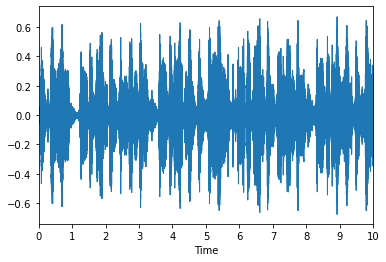

In [143]:
print(np.amax(sample), np.amin(sample))
## Waveplot
librosa.display.waveplot(sample[0], sr=SAMPLE_RATE)

In [ ]:
# Read The Data
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN)

In [149]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==2)[0]
print(hiphop_idx[:10])
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)
# ipd.Audio(X_train[hiphop_idx[2]], rate=22050) # raw file

<class 'numpy.ndarray'> (899, 1, 28000) (100, 1, 28000) (899,) (100, 1, 28000)
[6 8 8 0 3]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[ 24  34  53  62  65  73  80  87  98 105]


In [158]:
X_train_T = X_train.transpose([0,2,1]) # (N, T, 1)
X_test_T = X_test.transpose([0, 2, 1])

In [161]:
print(X_train_T.shape, X_test_T.shape)
ipd.Audio(X_train_T[hiphop_idx[2]].flatten(), rate=SAMPLE_RATE)

(899, 28000, 1) (100, 28000, 1)


In [150]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_SIZE = 1000
NUM_GENERES = len(np.unique(y_train))

In [162]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_T, y_test))
                 .batch(BATCH_SIZE))

In [194]:
print(np.amax(X_train_T), np.amin(X_train_T))
# print(np.amax(list(train_dataset.as_numpy_iterator())))

1.25347 -1.2156466


In [198]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)
print(sample_batch[0].numpy().squeeze())
print(tf.math.reduce_max(sample_batch).numpy(), tf.math.reduce_min(sample_batch).numpy(), )

(8, 28000, 1)
(8,) tf.Tensor([6 6 0 6 7 1 1 4], shape=(8,), dtype=int32)
[ 0.02133467  0.04445241  0.03203515 ... -0.00060176  0.10737859
  0.19353385]
1.0208381 -1.0228888


####Training Data Samples (1 per genre)

In [219]:
## Multiple Genres Case
idx_to_genres = {v:k for (k, v) in GENRES.items()}
# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train_T[int(generes_train_idx[i][0])])
  # Quantization Version
  # train_samples.append(X_train_Q[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape, train_samples[0])

{0: [3, 5, 18, 23, 25, 48], 1: [15, 27, 37, 39, 43, 46], 2: [24, 34, 53, 62, 65, 73], 3: [4, 30, 33, 40, 45, 55], 4: [6, 10, 12, 16, 20, 21], 5: [8, 9, 19, 41, 51, 81], 6: [0, 28, 35, 47, 56, 60], 7: [11, 13, 17, 22, 29, 38], 8: [1, 2, 7, 14, 42, 61], 9: [36, 44, 54, 67, 89, 106]}
(10, 28000, 1) [[-0.04690116]
 [-0.01698253]
 [-0.0486879 ]
 ...
 [ 0.02408239]
 [ 0.00038543]
 [-0.00345529]]


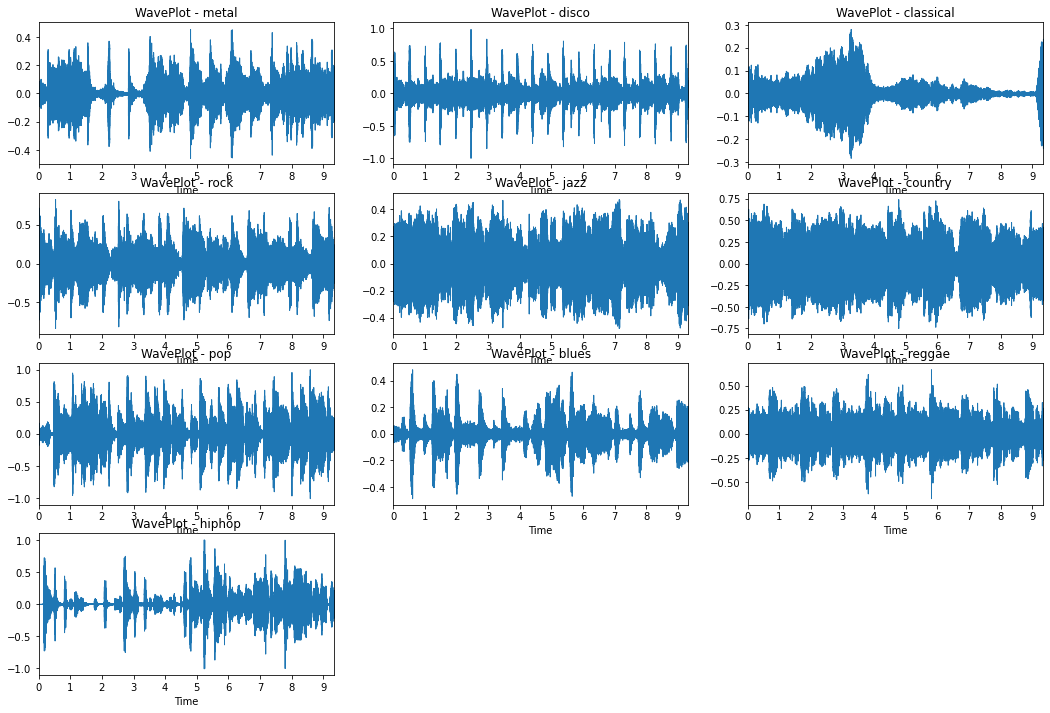

In [222]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
    
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(train_samples[i].squeeze(), sr=3000)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

## Model Structure

### VQ

In [166]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        # beta is the hyper-param to control the reluctance of changing the codebook latent code accroding to encoder output (scaled commitment loss)
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        ## Latent Embedding Space: K x D/L
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x, debug=False):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        # input x: 2D: (B, H, W, L); 1D: (B, T, L) -flatten-> (N, L)
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        ## (N, )
        encoding_indices = self.get_code_indices(flattened)
        # (N, K): get one-hot embedding for each instance/row of N
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        # (N, L): get the correcponding embedding for each instance of N from the codebook/E
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        # recover the previous flattened input to (B, H, W, L) in Image/Conv2D case
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        ## Training/BackProp: During backpropagation, (quantized - x) won't be included in the computation graph and gradients obtaind for quantized will be copied&&pasted for inputs
        quantized = x + tf.stop_gradient(quantized - x)

        ## DEBUG
        if debug:
          print("VQ input (Encoder Output): ", x)
          print("VQ output: ", quantized)
        return quantized

    '''
    Output shape: (N, )
    '''
    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        # (N, K)
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        # (N, K)
        distances = (
            # for each row/instance i of the flattened input
            # after broadcasting
            # zei^2 + ek^2 - 2(zei^Tek)
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0) # broadcast on (N, 1) and (1, K)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [167]:
test_latent_dim = 10
# the latent/embedding width needs to be shared between a.encoder output b. vq output and c. decoder input;
# should be treated as $$model width
test_VQ = VectorQuantizer(num_embeddings=6, embedding_dim=test_latent_dim)
test_VQ_out = test_VQ(tf.random.normal([32, 100, test_latent_dim]))

In [168]:
test_VQ_out.shape # [NTC]
test_VQ.embeddings.shape # (C, K)

TensorShape([10, 6])

#### Dialated Residual Block

In [169]:
def residual_stack(input, filters, dialation_factor=3, depth=3, reverse_dilation=False):
    """Convolutional residual stack with weight normalization.

       Dilated Conv: A dilated convolution effectively allows the network to operate on 
                     a coarser scale than with a normal convolution. This is similar to pooling or strided convolutions, but
                     here the $$output has the same size as the input$$.
    Args:
        filter: int, determines filter size for the residual stack. output_embed_width
        dilation_factor: dilation grow rate
        reverse_dilation: TODO
        depth: TODO, being 3 for now

    Returns:
        Residual stack output.
    """
    # c1 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=1, padding="same"), data_init=False
    # )(input)
    # lrelu1 = layers.LeakyReLU()(c1)
    # c2 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=1, padding="same"), data_init=False
    # )(lrelu1)
    # add1 = layers.Add()([c2, input])

    # lrelu2 = layers.LeakyReLU()(add1)
    # c3 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=3, padding="same"), data_init=False
    # )(lrelu2)
    # lrelu3 = layers.LeakyReLU()(c3)
    # c4 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=1, padding="same"), data_init=False
    # )(lrelu3)
    # add2 = layers.Add()([add1, c4])

    # lrelu4 = layers.LeakyReLU()(add2)
    # c5 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=9, padding="same"), data_init=False
    # )(lrelu4)
    # lrelu5 = layers.LeakyReLU()(c5)
    # c6 = addon_layers.WeightNormalization(
    #     layers.Conv1D(filters, 3, dilation_rate=1, padding="same"), data_init=False
    # )(lrelu5)
    # add3 = layers.Add()([c6, add2])
    
    # Depth of Residual block
    a1 = layers.ReLU()(input)
    # dilated Conv
    dr =dialation_factor ** 0 if not reverse_dilation else dialation_factor ** 2
    # d1 = layers.Conv1D(filters, 3, dilation_rate=dialation_factor ** 0 if not reverse_dilation else dialation_factor ** 2, padding="same", name=)(a1)
    d1 = layers.Conv1D(filters, 3, dilation_rate=dr, padding="same", name="dilation_cov1d_dr-{}".format(dr))(a1)
    a2 = layers.ReLU()(d1)
    c1 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a2)
    # residual connection
    r1 = layers.Add()([c1, input])

    a3 = layers.ReLU()(r1)
    # dilated Conv
    ## `strides > 1` not supported in conjunction with `dilation_rate > 1`. Received: strides=[2] and dilation_rate=[3]|
    dr = dilation_rate=dialation_factor ** 1
    d2 = layers.Conv1D(filters, 3, dilation_rate=dr,  padding="same", name="dilation_cov1d_dr-{}".format(dr))(a3)
    a4 = layers.ReLU()(d2)
    c2 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a4)
    # residual connection
    r2 = layers.Add()([c2, r1])

    a5 = layers.ReLU()(r2)
    # dilated Conv
    dr = dialation_factor ** 2 if not reverse_dilation else dialation_factor ** 0
    d3 = layers.Conv1D(filters, 3, dilation_rate=dr, padding="same", name="dilation_cov1d_dr-{}".format(dr))(a5)
    a6 = layers.ReLU()(d3)
    c3 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a6)
    # residual connection
    r3 = layers.Add()([c3, r2])


    return r3

In [170]:
test_in_shape = (128, 4) # (T, C)
test_fiters = 4 # out_channel size, needs to be same as input filters size for residual connection
test_in = keras.Input(test_in_shape)
test_out = residual_stack(test_in, test_fiters, reverse_dilation=True)
test_model = keras.Model(test_in, test_out)

test_model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 128, 4)]     0           []                               
                                                                                                  
 re_lu_776 (ReLU)               (None, 128, 4)       0           ['input_52[0][0]']               
                                                                                                  
 dilation_cov1d_dr-9 (Conv1D)   (None, 128, 4)       52          ['re_lu_776[0][0]']              
                                                                                                  
 re_lu_777 (ReLU)               (None, 128, 4)       0           ['dilation_cov1d_dr-9[0][0]']    
                                                                                           

In [171]:
print(test_model.layers[2])

In [172]:
# reverse
test_sample = tf.random.normal([32, 128, 4])
test_res_out = residual_stack(test_sample, test_fiters)
test_res_out.shape # dilation conv won't change input shape

TensorShape([32, 128, 4])

### Encoder

In [173]:
def create_encoder(input_shape, embed_width=64, output_embed_width=64):
    inp = keras.Input(input_shape)
    # x = MelSpec()(inp) // TODO, pre-processing?
    ## For each EncoderResidualConv block
    ## multiple down-sampling layers
    # # 1. down-sampling
    # x = layers.Conv1D(embed_width, 4, strides=2, padding="same")(inp)
    # # 2. Dilated Residual stack
    # # res_stack1 = residual_stack(x, embed_width)
    # res_stack1 = resnet.DilatedResnet1D(embed_width, 3, dilation_factor=3)(x)

    # # 3. Proj CONV with kernel==3
    # out1 = layers.Conv1D(output_embed_width, 3, strides=1, padding="same")(res_stack1)

    x = inp
    # Stack of Encoder Conv Block(s)
    for i in range(5): # hop_length being 2^5 == 32
      x = layers.Conv1D(embed_width, 4, strides=2, padding="same")(x)
      # deotg veubg 4
      x = resnet.DilatedResnet1D(embed_width, 4, dilation_factor=3)(x)

      # # make sure the down-sampling is working to reduce the sequence length
      # emb, T = embed_width, input_shape[-2] // (2 ** (i+1))
      # assert_shape(x, tf.TensorShape([None, emb, T]))

    conv_block_out = layers.Conv1D(output_embed_width, 3, strides=1, padding="same")(x)

    return keras.Model(inp, conv_block_out)

In [174]:
test_encoder = create_encoder(test_in_shape)
test_encoder.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 128, 4)]          0         
                                                                 
 conv1d_572 (Conv1D)         (None, 64, 64)            1088      
                                                                 
 dilated_resnet1d_82 (Dilate  (None, 64, 64)           98816     
 dResnet1D)                                                      
                                                                 
 conv1d_577 (Conv1D)         (None, 32, 64)            16448     
                                                                 
 dilated_resnet1d_83 (Dilate  (None, 32, 64)           98816     
 dResnet1D)                                                      
                                                                 
 conv1d_582 (Conv1D)         (None, 16, 64)            164

In [175]:
# DEV
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,4)))
# Afterwards, we do automatic shape inference:
model.add(tf.keras.layers.Dense(4))
model.add(layers.Conv1D(32, 3))

In [176]:
test_encoder.output.shape

TensorShape([None, 4, 64])

### Decoder
decoder mirrors the same structure of encoder while doing up-sampling (Conv1D Transpose)

In [177]:
'''
  Args:
  @embed_width: $normally the channel dimension shared across encoder_output, codebook quantized dim and decoder input dim (for gradient pass-through)
  @residual_block_width: TODO
'''
def create_decoder(input_shape, embed_width=64, output_embed_width=1):
    inp = keras.Input(input_shape)

    ## For each DecoderResidualConv block
    # # 0. pre-process projection layer
    # x = layers.Conv1D(embed_width, 3, strides=1, padding="same")(inp)
    # ### Multiple for each up-sampling layer
    # # 1. Dilated Residual stack
    # # res_stack1 = residual_stack(x, embed_width, reverse_dilation=True)# dilation reverted (27 -> 9 -> 3 -> 1)
    # res_stack1 = resnet.DilatedResnet1D(embed_width, 3, dilation_factor=3, reverse_dilation=True)(x)
    # # 2. up-sampling
    # ## TODO: for the last layer, need to map to the input_embed_width if residual_block_widt != embed_width
    # out1 = layers.Conv1DTranspose(embed_width, 4, strides=2, padding="same")(res_stack1) # output of first up-sampling layer

    ## Stack of Decoder Conv Block(s)
    x = inp

    # Stack of Encoder Conv Block(s)
    ## pre-process projection layer
    x = layers.Conv1D(embed_width, 3, strides=1, padding="same")(x)
    for i in range(5):
      x = resnet.DilatedResnet1D(embed_width, 4, dilation_factor=3, reverse_dilation=True)(x)
      # up-sampling
      x = layers.Conv1DTranspose(embed_width, 4, strides=2, padding="same")(x)
   


    # The final Conv1D projects to the desired number of audio channels
    proj = layers.Conv1D(output_embed_width, 3, strides=1, padding='same')(x)

    return keras.Model(inp, proj)

In [178]:
test_dec_in_shape = (100, 64) # (T, D)
test_decoder = create_decoder(test_dec_in_shape, embed_width=64)
test_decoder.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 100, 64)]         0         
                                                                 
 conv1d_599 (Conv1D)         (None, 100, 64)           12352     
                                                                 
 dilated_resnet1d_87 (Dilate  (None, 100, 64)          98816     
 dResnet1D)                                                      
                                                                 
 conv1d_transpose_25 (Conv1D  (None, 200, 64)          16448     
 Transpose)                                                      
                                                                 
 dilated_resnet1d_88 (Dilate  (None, 200, 64)          98816     
 dResnet1D)                                                      
                                                          

In [179]:
random_input = tf.random.normal([32, 256, 1]) # [NTC]
random_input.shape

TensorShape([32, 256, 1])

In [180]:
## encoder -> decoder E2E
# test_enc_out = test_encoder(random_input)

## VQ-VAE

In [181]:
'''
 Encoder -> Decoder E2E
 Hop-Length: 2^5 == 32

 Args:
 @latent_dim: model_width
'''
def get_vqvae(input_shape, latent_dim=64, num_embeddings=128):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = create_encoder(input_shape, embed_width=latent_dim)
    dec_in_shape = encoder.output.shape[1:]
    print("Decoder Input/Encoder Output Shape: {}".format(dec_in_shape))
    decoder = create_decoder(dec_in_shape, embed_width=latent_dim, output_embed_width=input_shape[-1]) # reconstruction shape should align with input channel width
    inputs = keras.Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    # print("VQ output:", quantized_latents)
    reconstructions = decoder(quantized_latents)
    # reconstructions = decoder(encoder_outputs)
    return keras.Model(inputs, reconstructions, name="vq_vae")

In [182]:
random_input.shape

TensorShape([32, 256, 1])

In [183]:
test_vqvae = get_vqvae(sample_batch.shape[1:], latent_dim=64, num_embeddings=512)
test_vqvae.summary()

Decoder Input/Encoder Output Shape: (875, 64)
Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 28000, 1)]        0         
                                                                 
 model_39 (Functional)       (None, 875, 64)           572544    
                                                                 
 vector_quantizer (VectorQua  (None, 875, 64)          32768     
 ntizer)                                                         
                                                                 
 model_40 (Functional)       (None, 28000, 1)          588865    
                                                                 
Total params: 1,194,177
Trainable params: 1,194,177
Non-trainable params: 0
_________________________________________________________________


In [184]:
test_vqvae_out = test_vqvae(sample_batch)
test_vqvae_out.shape

TensorShape([8, 28000, 1])

### Trainer

In [237]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, input_shape, latent_dim=32, num_embeddings=128, train_variance=1.0, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(input_shape, self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")
        self.loss_fn = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    """
       x being tuple of (batched_audio_waveform, genre_label)
    """
    @tf.function
    def train_step(self, data):
        x = data[0]
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            # reconstruction_loss = (
            #     tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            # )
            reconstruction_loss = tf.reduce_mean(self.loss_fn(x, reconstructions))
            
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    '''
      For CallBack model call
    '''
    def call(self, x):
      return self.vqvae(x)

In [261]:
vqvae_trainer = VQVAETrainer(sample_batch.shape[1:], latent_dim=64, num_embeddings=512) # codebook size
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

Decoder Input/Encoder Output Shape: (875, 64)


##### Validation

In [262]:
#### Validation between Epoches TODO: move to module
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample, if_quantized=False, channel_last=False):


  # Direct Reconstruction (x -> x')
  input = test_sample
  if channel_last:
    input = np.transpose(test_sample, [0,2,1])
  predictions = model(input).numpy()
  print("Reconstructed Output: ", predictions.shape)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  if if_quantized:
    # recover int waveform to float waveform
    # Greedy Sampling
    predictions = np.argmax(predictions, axis=-1)
    print("Sampled quantized: ", predictions.shape, predictions[0])

    predictions = mu_law_decode(predictions, QUANTIZATION_CHANNELS)

    print("Max: {}, Min: {}".format(np.amax(predictions), np.amin(predictions)))

  for i in range(predictions.shape[0]):
    waves = predictions[i]
    plt.subplot(4, 3, i + 1)

    if i==9:
      print("X': ", waves.squeeze())
      print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i])
    
  plt.show()

  return ret

In [263]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % 5 == 0:
        print("[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        generate_and_save_waves(self.model, epoch, train_samples)
        # generate_and_save_waves(self.model, epoch, train_samples, if_quantized=True, channel_last=True)

vae_monitor = VAEMonitor()

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.1095 - reconstruction_loss: 0.0172 - vqvae_loss: 0.0896[DEBUG] This is Callback Monitor: End of Epoch 0
Reconstructed Output:  (10, 28000, 1)
X':  [0.02071251 0.00145393 0.01086953 ... 0.00626897 0.00187706 0.00487728]
X range: [0.4171522259712219, -0.4546818137168884]


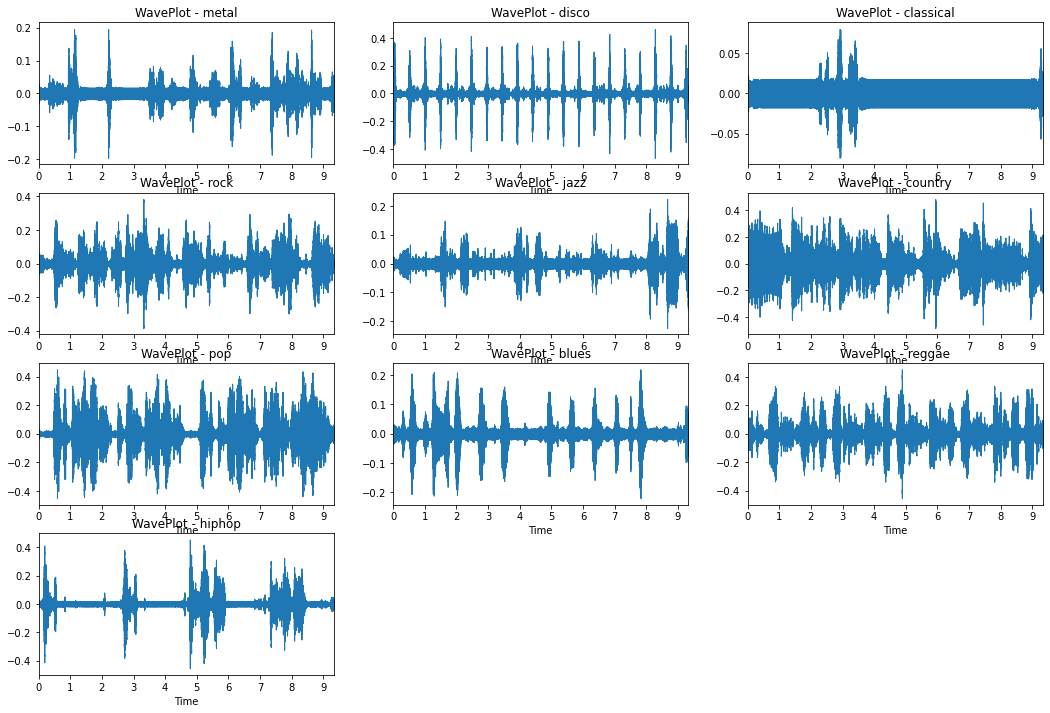

113/113 [==============================] - 25s 151ms/step - loss: 0.1104 - reconstruction_loss: 0.0172 - vqvae_loss: 0.0905
Epoch 2/100
113/113 [==============================] - 15s 137ms/step - loss: 0.1350 - reconstruction_loss: 0.0124 - vqvae_loss: 0.1216
Epoch 3/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0673 - reconstruction_loss: 0.0112 - vqvae_loss: 0.0557
Epoch 4/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0426 - reconstruction_loss: 0.0107 - vqvae_loss: 0.0321
Epoch 5/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0364 - reconstruction_loss: 0.0104 - vqvae_loss: 0.0258
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.0324 - reconstruction_loss: 0.0100 - vqvae_loss: 0.0226[DEBUG] This is Callback Monitor: End of Epoch 5
Reconstructed Output:  (10, 28000, 1)
X':  [ 0.0018362   0.00034671  0.00108282 ... -0.00913693 -0.00800669
 -0.00596315]
X range: [0.7903661131858826, -0.

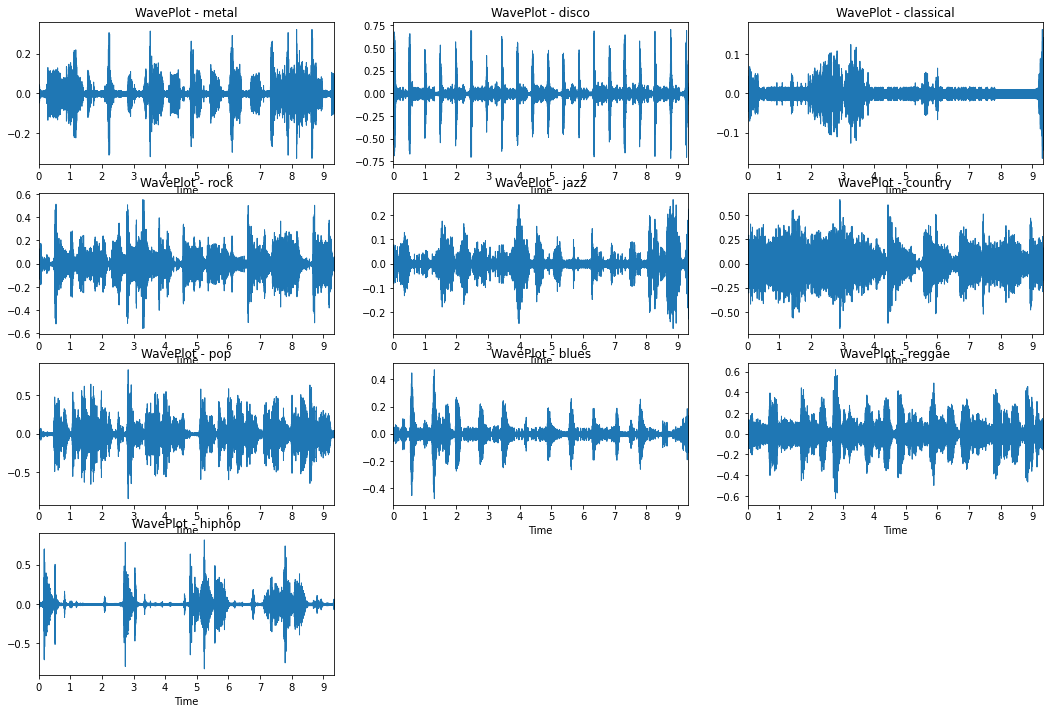

113/113 [==============================] - 17s 146ms/step - loss: 0.0324 - reconstruction_loss: 0.0100 - vqvae_loss: 0.0226
Epoch 7/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0312 - reconstruction_loss: 0.0096 - vqvae_loss: 0.0215
Epoch 8/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0320 - reconstruction_loss: 0.0094 - vqvae_loss: 0.0221
Epoch 9/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0271 - reconstruction_loss: 0.0093 - vqvae_loss: 0.0181
Epoch 10/100
113/113 [==============================] - 16s 138ms/step - loss: 0.0270 - reconstruction_loss: 0.0090 - vqvae_loss: 0.0182
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.0274 - reconstruction_loss: 0.0089 - vqvae_loss: 0.0181[DEBUG] This is Callback Monitor: End of Epoch 10
Reconstructed Output:  (10, 28000, 1)
X':  [0.00356983 0.00706015 0.00592505 ... 0.00599951 0.00782337 0.0025266 ]
X range: [0.5840443968772888, -0.6744

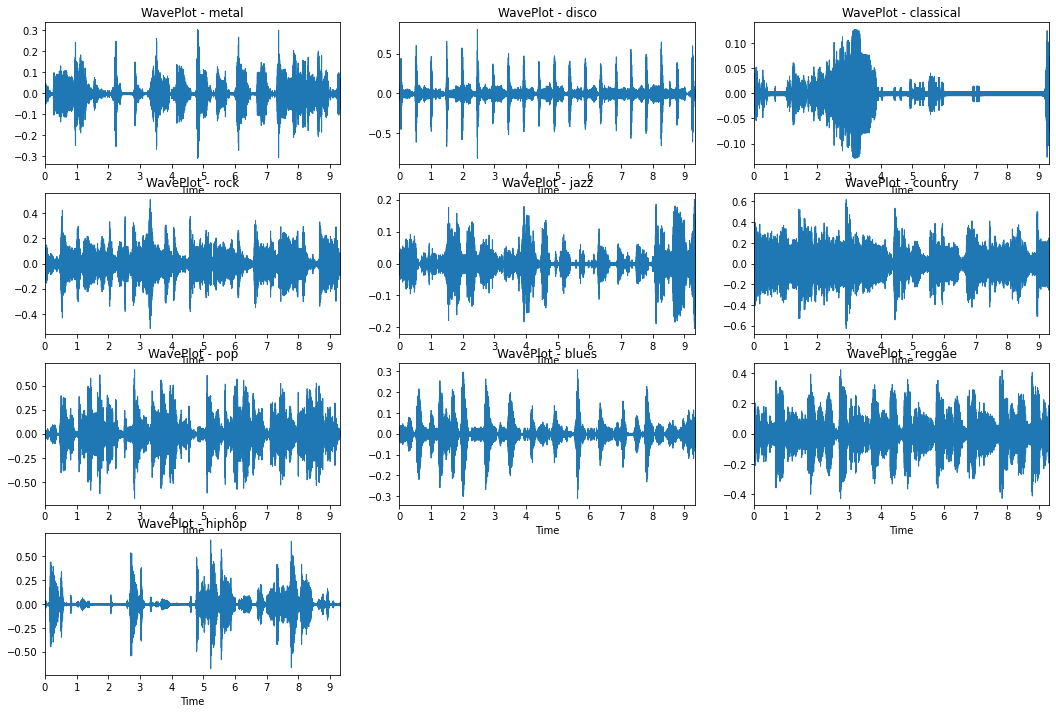

113/113 [==============================] - 17s 147ms/step - loss: 0.0274 - reconstruction_loss: 0.0089 - vqvae_loss: 0.0180
Epoch 12/100
113/113 [==============================] - 15s 135ms/step - loss: 0.0264 - reconstruction_loss: 0.0087 - vqvae_loss: 0.0176
Epoch 13/100
113/113 [==============================] - 15s 131ms/step - loss: 0.0256 - reconstruction_loss: 0.0086 - vqvae_loss: 0.0169
Epoch 14/100
113/113 [==============================] - 15s 131ms/step - loss: 0.0257 - reconstruction_loss: 0.0085 - vqvae_loss: 0.0168
Epoch 15/100
113/113 [==============================] - 15s 131ms/step - loss: 0.0245 - reconstruction_loss: 0.0086 - vqvae_loss: 0.0160
Epoch 16/100
113/113 [==============================] - ETA: 0s - loss: 0.0234 - reconstruction_loss: 0.0085 - vqvae_loss: 0.0151[DEBUG] This is Callback Monitor: End of Epoch 15
Reconstructed Output:  (10, 28000, 1)
X':  [0.00260926 0.00450908 0.00286045 ... 0.00485567 0.00638833 0.00197062]
X range: [0.7230938673019409, -0.7

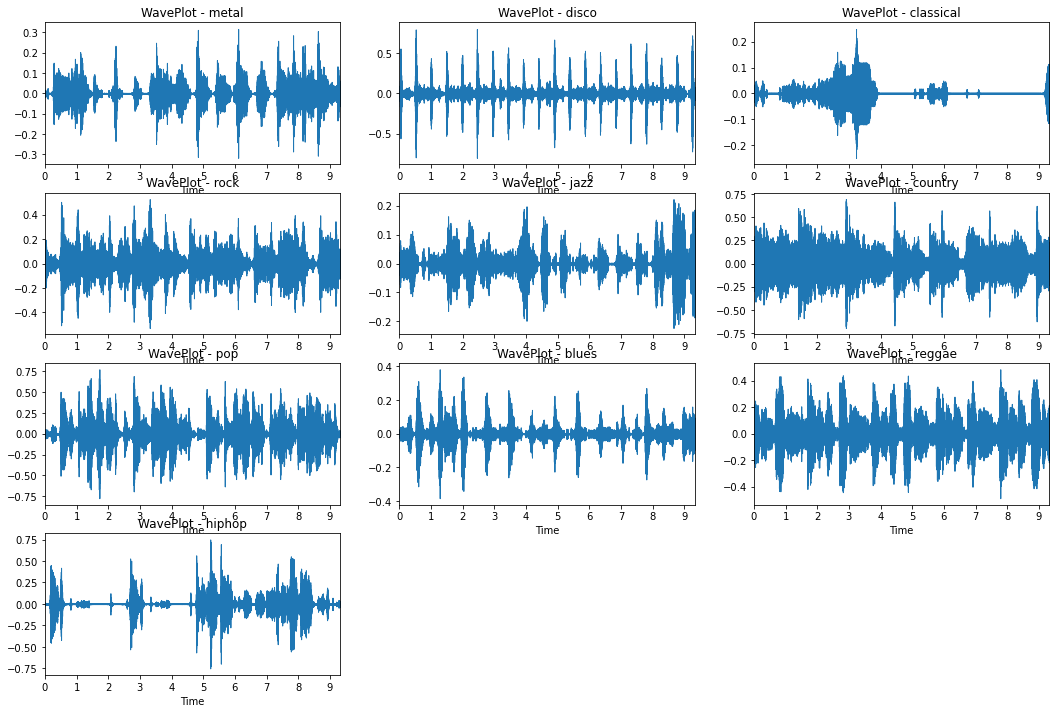

113/113 [==============================] - 16s 140ms/step - loss: 0.0234 - reconstruction_loss: 0.0085 - vqvae_loss: 0.0151
Epoch 17/100
113/113 [==============================] - 15s 135ms/step - loss: 0.0239 - reconstruction_loss: 0.0084 - vqvae_loss: 0.0157
Epoch 18/100
 25/113 [=====>........................] - ETA: 11s - loss: 0.0243 - reconstruction_loss: 0.0084 - vqvae_loss: 0.0158

In [ ]:
# Callback 0: Learning Rate Scheduler
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=0.0000001, min_delta=1.0)

vqvae_trainer.fit(train_dataset, epochs=100, callbacks=[vae_monitor])

Reconstructed Output:  (10, 28000, 1)
X':  [-0.00094131  0.00168424 -0.00329383 ...  0.02937312  0.02251232
  0.01055866]
X range: [0.8192777633666992, -0.7077847123146057]


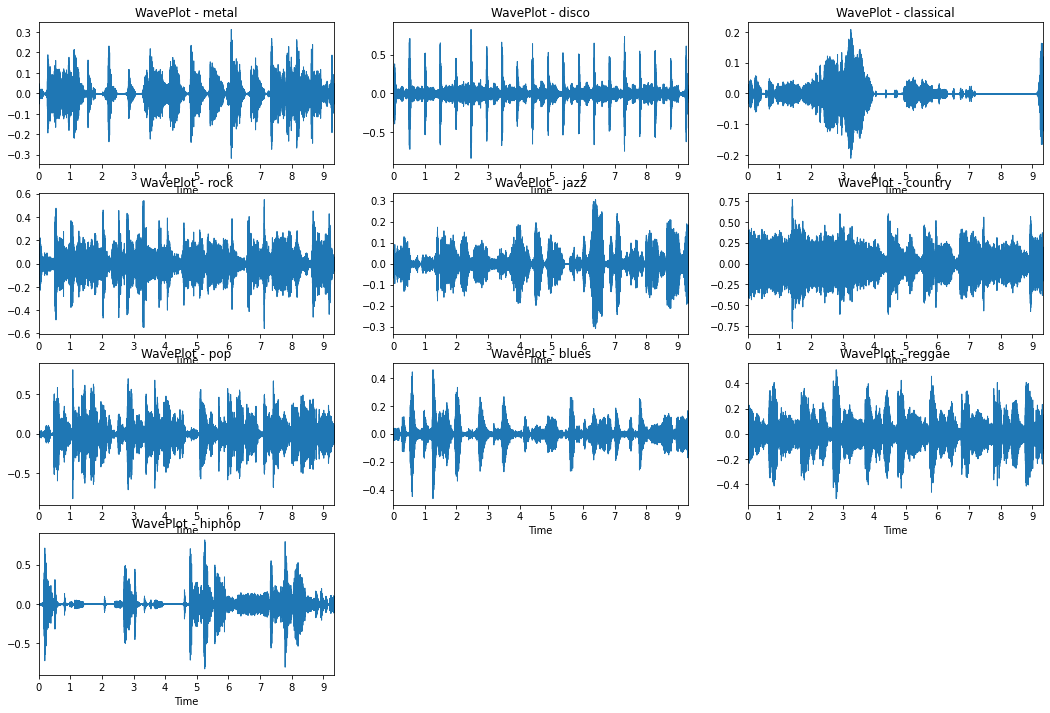

In [249]:
#### Inspect reconstructed sample
recon_train_samples = generate_and_save_waves(vqvae_trainer.vqvae, 0, train_samples)

In [260]:
ipd.Audio(train_samples[6].squeeze(), rate=SAMPLE_RATE)

In [259]:
ipd.Audio(recon_train_samples[6].squeeze(), rate=SAMPLE_RATE) # Metal Recon